In [1]:
import pandas as pd
import os
import openai
from dotenv import load_dotenv, find_dotenv

import seaborn as sns

In [2]:
load_dotenv(find_dotenv())
openai.api_key = os.environ.get("openai_api")

In [3]:
df = pd.read_csv("../data/raw/SentimentLabeled_10112022.csv")
df = df[["text", "Bucket", "country"]]
df["Relevant"] = df["Bucket"].apply(lambda x: x == "1")
df.drop(columns = ["Bucket"], inplace = True)
df.head()

,text,country,Relevant
0,I commend all of law enforcement for the secur...,China,False
1,"Socialist tyrant Maduro starves, tortures his ...",China,True
2,"Socialist tyrant Maduro starves, tortures his ...",Iran,False
3,Inhofe: The Canadians have already had convers...,Canada,False
4,Statement on Iran nuclear agreement. http://t....,Iran,False


In [4]:
def isRelevant(tweet):

    prompt = """
    You are a machine that will be given a Tweet from a U.S. politician, and you will be asked to determine its relevancy to one of three countries. If it is relevant, return "True". Otherwise, return "False".
    
    The three possible countries are Canada, Iran, or China. 
    A "relevant" tweet would have:
    - They express sentiment towards the country of interest, either positive or negative.
    - They discuss how only ONE of these countries' governments is having and impact on American politics. 

    EXAMPLE TWEET:
    "They are also an assault on the American-led world order, and a disturbing premonition of an alternative world order—one controlled by the Chinese Communist Party and one that ends in Room 101."

    EXAMPLE ANSWER: 
    True

    EXPLANATION:
    This tweet is clearly about the Chinese government and its impact over American politics. Hence, the return value is True. 

    EXAMPLE TWEET:
    "JUST IN: House votes to block Obama from lifting Iran sanctions https://t.co/EFI5L9WjI4"

    EXAMPLE ANSWER: 
    False

    EXPLANATION:
    This tweet, while mentioning Iran, does not reflect any substance over Iranian political effects on America. Its ONLY focus is on America, not Iranian impacts on America, and is thus irrelvant. 

    EXAMPLE TWEET:
    "The President’s border-crossing permit for the A2A Railway Development Corp is a big boost for efforts to connect Alaska’s rich resources to a global market via freight rail through Canada. https://t.co/baSaeN9Lym"

    EXAMPLE ANSWER: 
    True

    EXPLANATION:
    This tweet is about how Canadian freight reils allow for American political expansion, and is thus relevant about one of our three options.

    EXAMPLE TWEET:
    Months ago, all 100 Senators, Democrats &amp; Republicans alike, passed a bill to stop the influence of the Chinese government-funded Confucius Institute in US schools. The Dem-led House continues to block the legislation.

    Why is Pelosi playing politics with our national security?

    EXAMPLE ANSWER: 
    False

    EXPLANATION: 
    This Tweet, while discussing Chinese political impact on America, does NOT contain sentiment towards China. Instead, it focuses its sentiment towards America. Therefore, it's irrelevant. 

    EXAMPLE TWEET:
    .@grahamblog: If war continues, how will Iran take us seriously re: nuclear program if U.S. does nothing about Assad? #MTP

    EXAMPLE ANSWER:
    False

    EXPLANATION:
    Again, this Tweet mentions Iran-US relations, but the sentiment expressed is towards America, not Iran. Therefore, it's irrelevant. 
    
    TWEET: \n
    """

    prompt += tweet + "\n" + "ANSWER: \n\n"
    
    response = openai.Completion.create(engine = "text-davinci-003", prompt = prompt)
    answer = response["choices"][0]["text"].strip()
    
    return answer

def cleanAnswer(response):
   
    if "False" in response:

        return False

    else:

        return True

In [5]:
subset = df.sample(n = 100)
subset.head()

subset["gpt_Relevant"] = subset["text"].apply(isRelevant)
subset["gpt_Relevant"].value_counts()
subset["gpt_Relevant"] = subset["gpt_Relevant"].apply(cleanAnswer)
subset["gpt_Relevant"].value_counts()


True     82
False    18
Name: gpt_Relevant, dtype: int64

0.66

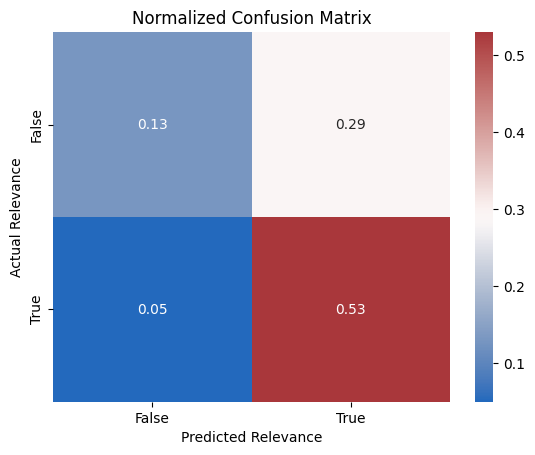

In [7]:
#subset["gpt_Relevant"] = subset["gpt_Relevant"].apply(cleanAnswer)
cm = (pd.crosstab(subset["Relevant"], subset["gpt_Relevant"]) / subset.shape[0])
cm = sns.heatmap(cm, annot = True, cmap=sns.color_palette("vlag", as_cmap=True))
cm.set_title("Normalized Confusion Matrix")
cm.set_xlabel("Predicted Relevance")
cm.set_ylabel("Actual Relevance")
cm.plot()

cm.get_figure().savefig("cm.png", dpi=300)

acc = (subset["Relevant"] == subset["gpt_Relevant"]).mean()
acc

In [16]:
errors = subset.loc[(subset["Relevant"] == False) & (subset["gpt_Relevant"] == True)]["text"]
errors.reset_index(inplace = True, drop = True)

for i in range(len(errors)):

    print(errors[i])
    print("--------")

The Canadian border is now open to vaccinated Americans. Here are a few quick reminders if you plan to travel:
➡️Get tested 72 hours in advance
➡️Have vaccine documentation
➡️Log info on ArriveCAN App
➡️Have a quarantine plan

https://t.co/igKdbwkpRF
--------
Of all the things we will do...I cant think of anything more important than getting the Iran nuclear ambitions right. http://t.co/Dwz9OA5oft
--------
“I had hoped Congresswoman Judy Chu would be able to testify today. As the 1st Chinese American woman elected to Congress she would have had a valuable perspective. But for the 1st time in 2 decades, the subcommittee refused.” Thank you @SenatorDurbin for fighting for our rights https://t.co/7V5zmPsyM2
--------
President Biden tonight has proudly laid out his job-killing anti-energy actions. #JointAddress

In the process of destroying American energy jobs, Biden is making America more and more dependent on countries like China and Russia for energy.
https://t.co/qvWPT5ITDh
--------
I

In [ ]:


# Tasks for Week 4 
# 1. Editing prompts (add more "relevance" explanation) 
# 2. Explore fine-tuning GPT-3 on Tweet data
# 3. BERT Tokenizer as control group (?)

